<center><h1>Projekt</h1></center>

<h2>Wszystki potrzebne biblioteki:</h2>

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io, color, img_as_ubyte, util
import copy
import warnings
from scipy.spatial import distance
import math
from scipy import ndimage as ndi
from skimage.morphology import watershed

<h2>Przydatne funkcje:</h2>

In [2]:
#Pokazywanie obrazu
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    
#Pokazujemy 2 obrazy obok siebie
def show2imgs(im1, im2, title1='Obraz pierwszy', title2='Obraz drugi', size=(10,10)):
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap='gray')
    ax1.axis('off')
    ax1.set_title(title1)

    ax2.imshow(im2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2)
    plt.show()
    

<h2>Wczytanie obrazka:</h2>

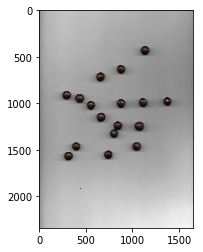

In [3]:
#nazwa obrazu
img_name ="img15"  
#folder
path = './img/'  
#wczyatnie obrazu
img_raw = io.imread(path +img_name+ '.jpg') 

#podgląd obrazu
show_img(img_raw)


<h2>Zamiana obrazu z RGB na odcienie szarości</h2>

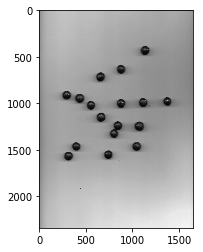

In [4]:
img_gray = cv2.cvtColor(img_raw,cv2.COLOR_BGR2GRAY)  
show_img(img_gray)

<h2> Binaryzacja </h2>

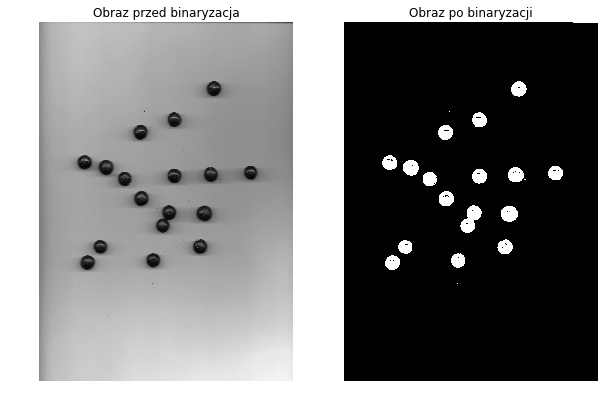

In [5]:
#ustawiamy próg binaryzacji na 220
th = 100
#dokonujemy binaryzacji z inversją
th, img_bin = cv2.threshold(img_gray, thresh=th, maxval=255, type=cv2.THRESH_BINARY_INV)
#pokazujemy obraz przed i po binaryzacji
show2imgs(img_gray,img_bin,'Obraz przed binaryzacja','Obraz po binaryzacji',(10,10))

<h2>Odzielamy od siebie obiekty</h2>

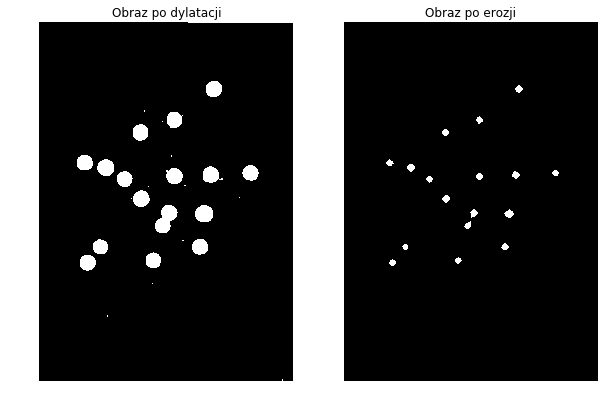

In [6]:
#Ustalamy rozmiar maski
kernel = np.ones((3,3),np.uint8)


#używamy dylatacji poraz pierwszy by pozbyc sie potencjalnych luk w obiektach
img_dyl = cv2.dilate(img_bin, kernel=kernel, iterations=3)

#używamy erozji w celu odzielenia obiektów od siebie
img_erode = cv2.erode(img_dyl, kernel=kernel, iterations=23)

#Zdjęcie ukazujace nam róznice przed i po  procesem rozdzielania obiektow
show2imgs(img_dyl,img_erode,'Obraz po dylatacji','Obraz po erozji',(10,10))

<h2>Proces segmentacji </h2>

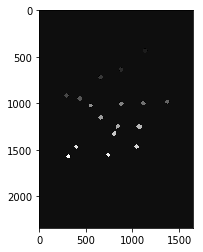

In [12]:
def segmentation(image):

    kernel = np.ones( (3,3), np.uint8 )
    
    background = cv2.dilate(image, kernel, iterations=1)

    distance_transform = cv2.distanceTransform(image, cv2.DIST_L2, 3)
    foreground = cv2.threshold(distance_transform, 0.5 * distance_transform.max(), 255, 0)[1]
    foreground = np.uint8(foreground)

    unknown = cv2.subtract(background, foreground)

    markers = cv2.connectedComponents(foreground)[1]

    markers += 1

    markers[unknown == 255] = 0

    markers = watershed(-distance_transform, markers, mask=image)
    #zwracamy obraz z obiektami rozdzielonymi od siebie oprzez kolory
    return markers
img_seg=segmentation(img_erode)
show_img(img_seg)

<h2>Zliczanie obiektów</h2>

In [8]:
#definujemy nasza funkcje do zliczania ilosci obiektów na zdjęciu
def objects_no(img):
    number = len(np.unique(img))-2
    return number
number = objects_no(img_seg)
#wywołanie naszej funkcji zliczajacej obiekty
print("W podanym przez nas obrazie znajduje sie:  ",number," obiektów.")


W podanym przez nas obrazie znajduje sie:   17  obiektów.


<h2>Liczenie jaki obszar zajmuja obiekty</h2>

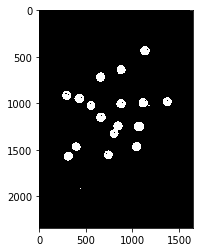

monety stanowią: 3.3 % z obrazu


In [9]:
#zliczamy ile pixeli zajmuja obiekty w tym celu użyjemy img_bin
show_img(img_bin)
def img_per(img):
    whole = 0
    part = 0
    for i in range( img.shape[0] ):
        for j in range(img.shape[1]):
            if(img[i][j] == 255):
                part+=1
            whole+=1
    return part/whole*100
print("monety stanowią: %.1f"%img_per(img_bin),"% z obrazu")


<h2>Środek ciężkosci</h2>

[(1169, 826), (436, 1137), (637, 881), (719, 660), (916, 297), (948, 436), (983, 1377), (996, 1117), (1004, 881), (1023, 556), (1151, 665), (1245, 845), (1249, 1076), (1323, 808), (1464, 1048), (1465, 399), (1552, 743), (1567, 315)]


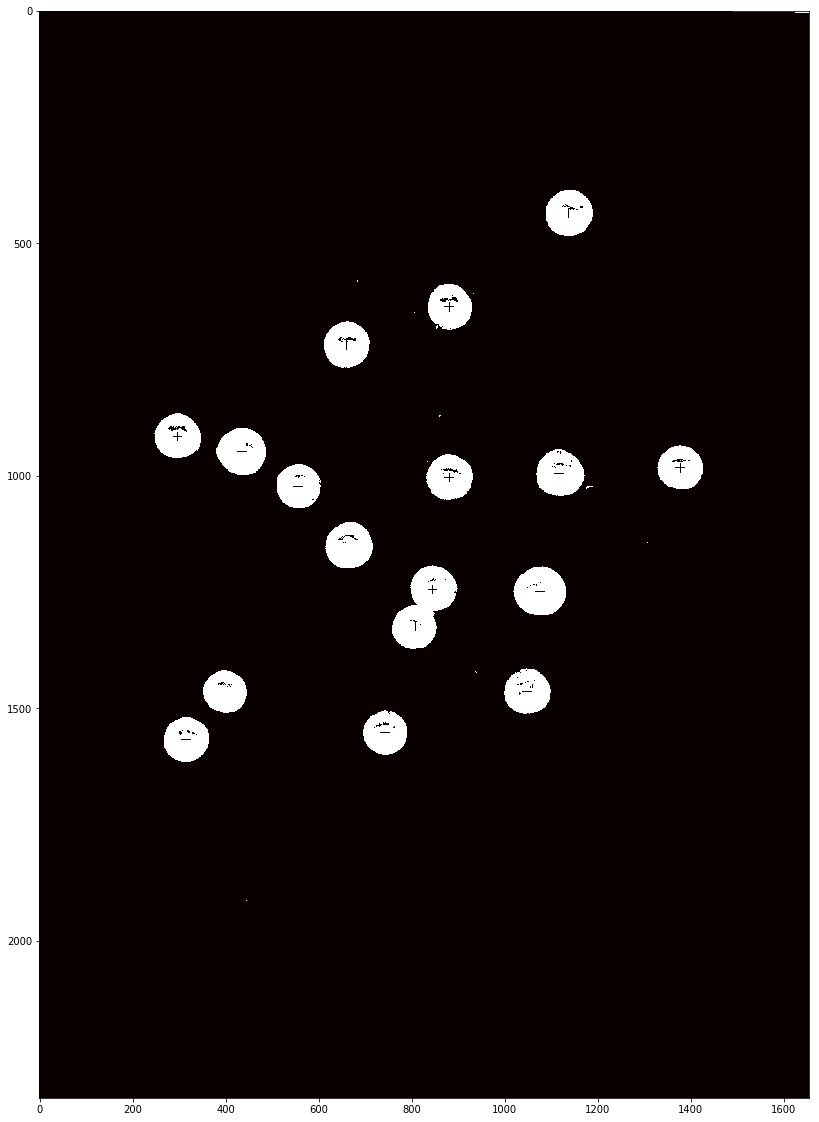

In [10]:

img_label, nb_labels = ndi.label(img_seg)
sizes = np.bincount(img_label.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
def cog(labelledImage, objNumber):
    cx = 0
    cy = 0
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                cy = cy + y
                cx = cx + x

    cx = cx / sizes[objNumber]
    cy = cy / sizes[objNumber]

    return int(cy), int(cx)

cogs = []
for i in range(nb_labels):
    cogs.append(cog(img_label, i+1))

print(cogs)

def drawMarkers(image, coords):

    image = np.copy(image)
    
    for item in coords:
        y,x = item
        for j in range(y-10, y+11):
            image[j,x] = 0
        for i in range(x-10, x+11):
            image[y,i] = 0
            
    return image


lo = drawMarkers(img_bin, cogs)
plt.figure(figsize=(20,20))
plt.imshow(lo,cmap='hot')
plt.show()

<h2>Liczenie Współczynników: </h2>
<ul><li>Feret</li>
<li>Blair-Bliss</li>
<li>Środka ciężkosci</li>
<li>Liczba punktów</li></ul>

In [13]:

###########################################

def getFigure(labelledImage, objNumber):
    
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                points.append((y,x))

    return points

############################################

def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]

############################################

def computeFeret(points):
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)  

#############################################
def computeBB(points):
    
    s = len(points)
    my,mx = cog2(pts)
    
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
            
    return s/(math.sqrt(2*math.pi*r))

###############################################

for i in range(nb_labels):
    pts = getFigure(img_label, i+1)
    bb = computeBB(pts)
    feret = computeFeret(pts)
    
    print('Numer obiektu: ',i+1,'\nLiczba punktow: ',len(pts),'\nSrodek ciezkosci: ', cog2(pts),'\nBlair-Bliss: ', bb,'\nFeret: ',feret, '\n---\n')

Numer obiektu:  1 
Liczba punktow:  3836568 
Srodek ciezkosci:  [1169.120237410102, 826.7515274067865] 
Blair-Bliss:  0.9424908869726156 
Feret:  1.4137931034482758 
---

Numer obiektu:  2 
Liczba punktow:  1708 
Srodek ciezkosci:  [436.50409836065575, 1137.9941451990633] 
Blair-Bliss:  0.9936260064660922 
Feret:  0.9803921568627451 
---

Numer obiektu:  3 
Liczba punktow:  1451 
Srodek ciezkosci:  [637.9028256374913, 881.1943487250172] 
Blair-Bliss:  0.9867928562026248 
Feret:  1.065217391304348 
---

Numer obiektu:  4 
Liczba punktow:  1582 
Srodek ciezkosci:  [719.5158027812895, 660.6637168141593] 
Blair-Bliss:  0.9927914770455577 
Feret:  1.0 
---

Numer obiektu:  5 
Liczba punktow:  1488 
Srodek ciezkosci:  [916.497311827957, 297.34879032258067] 
Blair-Bliss:  0.9894923481652979 
Feret:  0.9387755102040817 
---

Numer obiektu:  6 
Liczba punktow:  1877 
Srodek ciezkosci:  [948.6995205114545, 436.101758124667] 
Blair-Bliss:  0.9916430324157122 
Feret:  0.9636363636363636 
---

Nume

<h2> Podsumowanie</h2>


In [14]:
#tablica wyniów
tab=[11,11,11,15,12,12,12,12,13,13,14,14,17,17,17,20]

In [16]:
bad_result=0
for i in range(len(tab)):
    #nazwa obrazu
    img_name ="img"+str(i+1)
    #folder
    path = './img/'  
    #wczyatnie obrazu
    img_raw = io.imread(path +img_name+ '.jpg') 
    
    img_gray = cv2.cvtColor(img_raw,cv2.COLOR_BGR2GRAY)
    
    #ustawiamy próg binaryzacji na 220
    th = 60
    #dokonujemy binaryzacji z inversją
    th, img_bin = cv2.threshold(img_gray, thresh=th, maxval=255, type=cv2.THRESH_BINARY_INV)
    #pokazujemy obraz przed i po binaryzacji

    #Ustalamy rozmiar maski
    kernel = np.ones((3,3),np.uint8)


    #używamy dylatacji poraz pierwszy by pozbyc sie potencjalnych luk w obiektach
    img_dyl = cv2.dilate(img_bin, kernel=kernel, iterations=3)

    #używamy erozji w celu odzielenia obiektów od siebie
    img_erode = cv2.erode(img_dyl, kernel=kernel, iterations=12)

    img_seg=segmentation(img_erode)
    #show_img(img_seg)
    number = objects_no(img_seg)
    #wywołanie naszej funkcji zliczajacej obiekty
    correct=True
    if(tab[i]!=number):
        bad_result+=1
        correct=False
    if correct:
        yes_no=' Poprawnie'
    else:
        yes_no=' Nie poprawnie'
    print("Obraz numer ",i+1," posiada: ",number ," obiektów, program działa: ",yes_no)

print('Nasz program wywołuje sie poprawnie w: ',(len(tab)-bad_result)/len(tab)*100,'% ')
    

Obraz numer  1  posiada:  11  obiektów, program działa:   Poprawnie
Obraz numer  2  posiada:  11  obiektów, program działa:   Poprawnie
Obraz numer  3  posiada:  11  obiektów, program działa:   Poprawnie
Obraz numer  4  posiada:  15  obiektów, program działa:   Poprawnie
Obraz numer  5  posiada:  12  obiektów, program działa:   Poprawnie
Obraz numer  6  posiada:  12  obiektów, program działa:   Poprawnie
Obraz numer  7  posiada:  12  obiektów, program działa:   Poprawnie
Obraz numer  8  posiada:  12  obiektów, program działa:   Poprawnie
Obraz numer  9  posiada:  13  obiektów, program działa:   Poprawnie
Obraz numer  10  posiada:  13  obiektów, program działa:   Poprawnie
Obraz numer  11  posiada:  14  obiektów, program działa:   Poprawnie
Obraz numer  12  posiada:  14  obiektów, program działa:   Poprawnie
Obraz numer  13  posiada:  17  obiektów, program działa:   Poprawnie
Obraz numer  14  posiada:  17  obiektów, program działa:   Poprawnie
Obraz numer  15  posiada:  17  obiektów, pr